In [ ]:
pip install segmentation-models
pip install tensorflow==2.8 keras==2.8

# New Nodel


# ***importing Libraries***

In [30]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import MeanIoU
num_classes = 5

# ***Loading Data***

In [3]:
# Dataset directories
TRAIN_IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/Images"  # e.g., "diabetic-retinopathy-dataset/Daataset DR/DB0/Images"
TRAIN_MASK_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/GroundTruth"  # e.g., "diabetic-retinopathy-dataset/Daataset DR/DB0/GroundTruth"

TEST_IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/Images"  # e.g., "diabetic-retinopathy-dataset/Daataset DR/DB1/Images"
TEST_MASK_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/GroundTruth"      # Replace with your testing mask directory

img_size = 256

OUTPUT_SIZE = (img_size, img_size)
iou_metric = MeanIoU(num_classes=num_classes)


In [ ]:

#os.remove('/kaggle/working/model1.keras')

# ***Data Preprocessing***

## ***Combining Masks into separate channels***

In [4]:
# Combining Masks into separate channels
def combine_masks(cws_path, h_path, he_path, ma_path):
    cws = cv2.imread(cws_path, cv2.IMREAD_GRAYSCALE)
    h = cv2.imread(h_path, cv2.IMREAD_GRAYSCALE)
    he = cv2.imread(he_path, cv2.IMREAD_GRAYSCALE)
    ma = cv2.imread(ma_path, cv2.IMREAD_GRAYSCALE)
    
    target_shape=(cws.shape[0], cws.shape[1], 5)
    mask = np.zeros(target_shape, dtype=np.uint8)
    mask[:, :, 0] = (cws > 0)  # Class 1
    mask[:, :, 1] = (h > 0)    # Class 2
    mask[:, :, 2] = (he > 0)   # Class 3
    mask[:, :, 3] = (ma > 0)   # Class 4
    mask[:, :, 4] = (1 - np.sum(mask[:, :, :4], axis=-1))  # Background
    return mask


In [5]:
# Preprocess Data
def preprocess_data(image_dir, mask_dir, size=(img_size, img_size)):
    images = []
    masks = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        base_name = os.path.splitext(image_file)[0]
        mask_cws = os.path.join(mask_dir, "CWS", base_name + ".png")
        mask_h = os.path.join(mask_dir, "H", base_name + ".png")
        mask_he = os.path.join(mask_dir, "HE", base_name + ".png")
        mask_ma = os.path.join(mask_dir, "MA", base_name + ".png")

        # Read and resize images and masks
        image = cv2.imread(image_path)
        
        # Color BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size) / 255.0
        
        mask = combine_masks(mask_cws, mask_h, mask_he, mask_ma)
        mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

## ***Loading the Data***

In [6]:
from tensorflow.keras.utils import to_categorical
train_images, train_masks = preprocess_data(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, size=OUTPUT_SIZE)
test_images, test_masks = preprocess_data(TEST_IMAGE_DIR, TEST_MASK_DIR, size=OUTPUT_SIZE)

In [7]:
train_masks.shape, test_masks.shape

((130, 256, 256, 5), (89, 256, 256, 5))

In [8]:
train_images.shape, test_images.shape

((130, 256, 256, 3), (89, 256, 256, 3))

## ***Augmentation***

In [ ]:
import albumentations as A
from albumentations.core.composition import OneOf
from tensorflow.keras.utils import to_categorical

In [ ]:
# Data Augmentation Function
def augment_data(image, mask):
    # Define the augmentation pipeline
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),  # Random horizontal flip
        A.VerticalFlip(p=0.5),    # Random vertical flip
        A.Rotate(limit=30, p=0.5), # Random rotation
        A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast
    ])
    
    # Apply augmentations
    augmented = aug(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Preprocess and Augment Data
def preprocess_data_with_augmentation(image_dir, mask_dir, size=(img_size, img_size), augment=False):
    images = []
    masks = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        base_name = os.path.splitext(image_file)[0]
        mask_cws = os.path.join(mask_dir, "CWS", base_name + ".png")
        mask_h = os.path.join(mask_dir, "H", base_name + ".png")
        mask_he = os.path.join(mask_dir, "HE", base_name + ".png")
        mask_ma = os.path.join(mask_dir, "MA", base_name + ".png")

        # Read and resize images and masks
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size) / 255.0
        
        mask = combine_masks(mask_cws, mask_h, mask_he, mask_ma)
        mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

        if augment:
            image, mask = augment_data(image, mask)

        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Load and Augment Training Data
train_images_2, train_masks_2 = preprocess_data_with_augmentation(
    TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, size=OUTPUT_SIZE, augment=True
)
"""
# Load Testing Data (no augmentation)
test_images, test_masks = preprocess_data_with_augmentation(
    TEST_IMAGE_DIR, TEST_MASK_DIR, size=OUTPUT_SIZE, augment=False
)
"""

pass

In [ ]:
train_images_2.shape, train_masks_2.shape

### ***Combine Augmented images with original***

In [ ]:
# Combine Augmented images with original
combined_train_images = np.concatenate((train_images, train_images_2), axis=0)
combined_train_masks = np.concatenate((train_masks, train_masks_2), axis=0)
del train_images_2, train_masks_2, train_images, train_masks, A, OneOf

In [ ]:
combined_train_images.shape, combined_train_masks.shape

## ***One-Hot Encoding***

In [ ]:
# Convert masks to categorical format
# No need in current Implementation
categorical_train_mask = to_categorical(combined_train_masks, num_classes=num_classes)
categorical_test_mask = to_categorical(test_masks, num_classes=num_classes)
categorical_train_mask.shape, categorical_test_mask.shape

# ***Pretrained Model***

In [9]:
!pip install keras-unet-collection

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.5 MB/s eta 0:00:00


In [26]:
from keras_unet_collection import models
# e.g. models.unet_2d(...)

Encoder = backbone(VGG16) our model extract feature which is already learned(pre trained model)

Decoder = Unet3plus

Weights = imagenet weights will be initialization (achive the global minima fast)

In [31]:
unet = models.unet_3plus_2d(input_size=(img_size, img_size, 3), n_labels=5, filter_num_down=[128, 256, 512], backbone='VGG16', weights='imagenet', freeze_backbone=True, output_activation= 'Softmax')

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [128, 128]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 384


In [32]:
unet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VGG16_backbone      │ [(None, 256, 256, │  1,735,488 │ input_layer_5[0]… │
│ (Functional)        │ 64), (None, 128,  │            │                   │
│                     │ 128, 128), (None, │            │                   │
│                     │ 64, 64, 256)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_up_0_en0… │ (None, 128, 128,  │          0 │ VGG16_backbone[0… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_down_fro… │ (None, 128, 128,  │    295,040 │ unet3plus_up_0_e… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_down_fro… │ (None, 128, 128,  │    147,584 │ VGG16_backbone[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_down_fro… │ (None, 128, 128,  │          0 │ unet3plus_down_f… │
│ (ReLU)              │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_down_fro… │ (None, 128, 128,  │          0 │ unet3plus_down_f… │
│ (ReLU)              │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_concat_0  │ (None, 128, 128,  │          0 │ unet3plus_down_f… │
│ (Concatenate)       │ 256)              │            │ unet3plus_down_f… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_fusion_c… │ (None, 128, 128,  │    884,736 │ unet3plus_concat… │
│ (Conv2D)            │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_fusion_c… │ (None, 128, 128,  │      1,536 │ unet3plus_fusion… │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_fusion_c… │ (None, 128, 128,  │          0 │ unet3plus_fusion… │
│ (ReLU)              │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_up_1_en0… │ (None, 256, 256,  │          0 │ VGG16_backbone[0… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_up_1_en1… │ (None, 256, 256,  │          0 │ unet3plus_fusion… │
│ (UpSampling2D)      │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_down_fro… │ (None, 256, 256,  │    295,040 │ unet3plus_up_1_e… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_down_fro… │ (None, 256, 256,  │    442,496 │ unet3plus_up_1_e… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unet3plus_down_fro… │ (None, 256, 256,  │          0 │ unet3plus_down_f… │
│ (ReLU)              │ 128)              │            │                 

 Total params: 4,705,477 (17.95 MB)

 Trainable params: 2,968,453 (11.32 MB)

 Non-trainable params: 1,737,024 (6.63 MB)

# Custom Unet

In [ ]:
from tensorflow.keras.regularizers import l2
# Define U-Net Model
def custom_unet(input_shape=(img_size, img_size, 3), num_classes=num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-4), dilation_rate=(2, 2))(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2))(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), dilation_rate=(2, 2))(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), dilation_rate=(2, 2))(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    """
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2))(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2))(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c4)
    """
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p2)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c4)
    
    # Decoder
    """
    u6 = UpSampling2D((2, 2))(c4)
    u6 = Concatenate()([u6, c3])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    """
    
    u7 = UpSampling2D((2, 2))(c4)
    u7 = Concatenate()([u7, c2])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c1])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), padding='same')(c8)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c8)

    model = Model(inputs, outputs)
    
    return model
# Build U-Net model
model = custom_unet(input_shape=(img_size, img_size, 3), num_classes=num_classes)
model.compile(optimizer='adam',
              loss=jaccard_loss,
              metrics=[iou_metric])

# Callbacks
#checkpoint = ModelCheckpoint("unet_model2.keras", save_best_only=True, monitor="val_loss")
#early_stopping = EarlyStopping(patience=10, monitor="val_loss")
model.summary()

# ***Computing Class Weights***

In [33]:
from keras_unet_collection.losses import dice, dice_coef, iou_seg

In [34]:
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(np.argmax(train_masks, axis=-1).flatten()), 
    y=np.argmax(test_masks, axis=-1).flatten()
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [35]:
class_weight_dict

{0: 1226.6464773922187,
 1: 141.96675185590848,
 2: 279.61188878235856,
 3: 954.616039279869,
 4: 0.20050057217579081}

## ***Sample Weights***

In [36]:
############ For Losses other than CrossEntropy loss  ##############
def compute_sample_weights(masks, class_weight_dict):
    flattened_masks = masks.reshape(-1)
    sample_weights = np.array([class_weight_dict.get(int(label), 1.0) for label in flattened_masks])
    return sample_weights.reshape(masks.shape)

In [37]:
##########    For CrossEntropy Loss  ###################

def compute_sample_weights(masks, class_weight_dict):
    """
    Computes sample weights based on the class weights for each pixel.

    Args:
        masks: Numpy array of ground truth masks (categorical, one-hot or index-based).
        class_weight_dict: Dictionary mapping class indices to weights.

    Returns:
        Numpy array of sample weights with shape (batch_size, height, width).
    """
    if masks.ndim == 4:  
        masks = np.argmax(masks, axis=-1) 
    sample_weights = np.zeros_like(masks, dtype=np.float32)
    for class_idx, weight in class_weight_dict.items():
        sample_weights[masks == class_idx] = weight
    
    return sample_weights

# Model Training

In [38]:

# Create the LearningRateScheduler callback
#lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

unet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[iou_metric])
# Train the Model
def train_model(model = None, t_img = None, t_mask= None,
                valid_img=None, valid_mask= None ):
    
    # Train the model
    sample_weights = compute_sample_weights(t_mask, class_weight_dict)
    
    history = model.fit(x=t_img, y=t_mask,
                        validation_data=(valid_img, valid_mask),
                        epochs=10,
                        batch_size=8,
                        shuffle=True,
                        sample_weight=sample_weights,
                        ) # callbacks=[lr_scheduler]

    return model, history

# Run Training and Testing
if __name__ == "__main__":
    model, history = train_model(model= unet, t_img=train_images, t_mask=train_masks,
                                 valid_img= test_images, valid_mask=test_masks)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 930ms/step - loss: 1.6554 - mean_io_u: 0.2580 - val_loss: 0.8571 - val_mean_io_u: 0.4277
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 737ms/step - loss: 0.8551 - mean_io_u: 0.3749 - val_loss: 0.3616 - val_mean_io_u: 0.4534
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - loss: 0.6022 - mean_io_u: 0.3749 - val_loss: 0.2962 - val_mean_io_u: 0.4062
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 740ms/step - loss: 0.5093 - mean_io_u: 0.3749 - val_loss: 0.1116 - val_mean_io_u: 0.3977
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step - loss: 0.4690 - mean_io_u: 0.3749 - val_loss: 0.0459 - val_mean_io_u: 0.4053
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - loss: 0.4613 - mean_io_u: 0.3763 - val_loss: 0.0447 - val_mean_io_u: 0.3883
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - loss: 0.3746 - mean_io_u: 0.3749 - val_loss: 0.1763 - val_mean_io_u: 0.3712
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 745ms/step - loss: 0.2572 - mean_io_u: 0.

In [39]:
# Save Model
model.save('/kaggle/working/01Model_U3Plus.keras')

## Confusion Matrix

In [40]:
from sklearn.metrics import confusion_matrix

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step


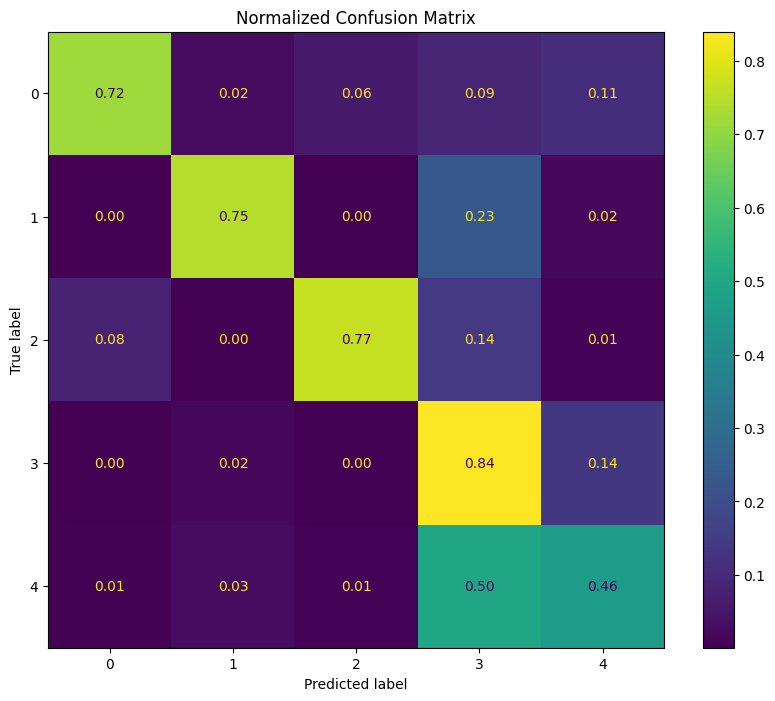

In [41]:
def plot_confusion_matrix(model, test_images, test_masks, num_classes):
    """
    Generate and plot the confusion matrix for the multi-class segmentation task.

    Args:
        model: Trained Keras model.
        test_images: Array of test images.
        test_masks: Array of true masks for test data (one-hot or class indices).
        num_classes: Number of classes in the segmentation task.
    """
    predictions = model.predict(test_images, batch_size=8)
    predicted_labels = np.argmax(predictions, axis=-1)  
    if test_masks.ndim == 4:  
        test_masks = np.argmax(test_masks, axis=-1) 

    true_labels = test_masks.flatten()
    predicted_labels = predicted_labels.flatten()

    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=list(range(num_classes)))
    disp.plot(ax=ax, cmap='viridis', values_format='.2f')
    plt.title("Normalized Confusion Matrix")
    plt.show()

test_images, test_masks = preprocess_data(TEST_IMAGE_DIR, TEST_MASK_DIR, size=OUTPUT_SIZE)

# Plot the confusion matrix
plot_confusion_matrix(model, test_images, test_masks, num_classes)




## ***Laoding Model***

In [58]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = '/kaggle/working/01Model_U3Plus.keras'

# Load the model
model = load_model(model_path)

# Print model summary to verify
#model.summary()


## Inference

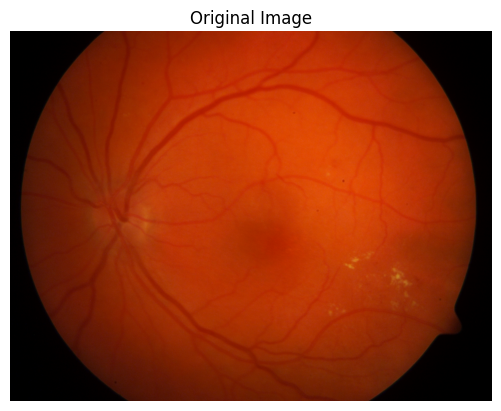

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


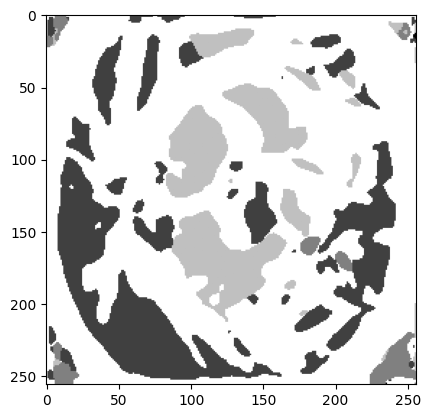

In [70]:
original_image_path = '/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/Images/image030.png'

# Load the image using OpenCV
image = cv2.imread(original_image_path, 1)  # Load image in BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format for correct colors

# Display the image
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")  # Hide axes
plt.show()
def inference(path=path, image_size = 256, model=model):
    im = cv2.imread(path, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (image_size, img_size))
    pred = model.predict(np.expand_dims(im, axis=0))[0]
    mask = np.argmax(pred, axis=-1)
    return mask

path = '/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/Images/image030.png'
mask = inference(path=path, image_size=image_size, model=model)
plt.imshow(mask, cmap='gray')

In [67]:
np.unique(mask)

array([0, 1, 2, 3, 4])

In [68]:
true_mask = mask
true_mask.flatten()
pixel_counts = np.bincount(true_mask.flatten())

# Print the pixel counts for each class (excluding b ackground if it's class 0)
for class_idx, count in enumerate(pixel_counts):
    print(f"Class {class_idx}: {count} pixels")

Class 0: 7 pixels
Class 1: 13302 pixels
Class 2: 1304 pixels
Class 3: 7594 pixels
Class 4: 43329 pixels
